Must install `imagecodecs` using pip __not__ conda!  (See [this issue](https://github.com/cgohlke/imagecodecs/issues/29))

In [159]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from imagecodecs.numcodecs import JpegXl, Jpeg2k, Jpeg
import numcodecs
from numcodecs.registry import register_codec

plt.rcParams["figure.figsize"] = (20, 12)

In [101]:
SRC_SATELLITE_ZARR_PATH = "gs://public-datasets-eumetsat-solar-forecasting/satellite/EUMETSAT/SEVIRI_RSS/v3/eumetsat_seviri_hrv_uk.zarr" 

In [3]:
satellite_dataset = xr.open_dataset(
    SRC_SATELLITE_ZARR_PATH, 
    engine="zarr", 
    chunks={},  # Load using Dask, using the same chunks as used in the original Zarr dataset.
)

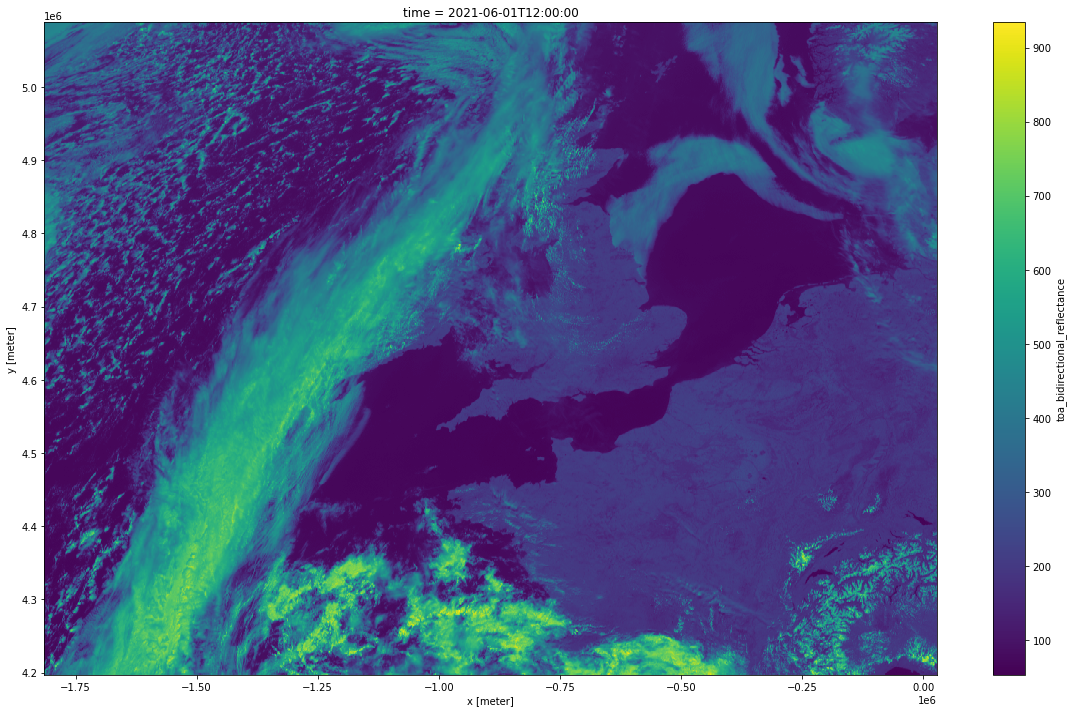

In [4]:
DATETIME_TO_PLOT = "2021-06-01 12:00"
satellite_data_array = satellite_dataset['data']
satellite_data_array.sel(time=DATETIME_TO_PLOT).plot();

```
$cjxl --help

JPEG XL encoder v0.7.0 7613f62 [AVX2,SSE4,SSSE3,Scalar]
Usage: cjxl INPUT OUTPUT [OPTIONS...]
 INPUT
    the input can be PNG, APNG, GIF, JPEG, EXR, PPM, PFM, or PGX
 OUTPUT
    the compressed JXL output file (can be omitted for benchmarking)
 -d maxError, --distance=maxError
    Max. butteraugli distance, lower = higher quality. Range: 0 .. 25.
    0.0 = mathematically lossless. Default for already-lossy input (JPEG/GIF).
    1.0 = visually lossless. Default for other input.
    Recommended range: 0.5 .. 3.0.
 -q QUALITY, --quality=QUALITY
    Quality setting (is remapped to --distance). Range: -inf .. 100.
    100 = mathematically lossless. Default for already-lossy input (JPEG/GIF).
    Positive quality values roughly match libjpeg quality.
 -e EFFORT, --effort=EFFORT
    Encoder effort setting. Range: 1 .. 9.
    Default: 7. Higher number is more effort (slower).
 -p, --progressive
    Enable progressive/responsive decoding.
 --resampling=0|1|2|4|8
    Subsample all color channels by this factor, or use 0 to choose the resampling factor based on distance.
 -v, --verbose
    Verbose output; can be repeated, also applies to help (!).
 -h, --help
    Prints this help message (use -v to see more options).

```

In [5]:
MATHEMATICALLY_LOSSLESS_DISTANCE = 0
VISUALLY_LOSSLESS_DISTANCE = 1

In [6]:
satellite_dataset

<xarray.Dataset>
Dimensions:  (time: 173624, y: 891, x: 1843)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Data variables:
    data     (time, y, x) int16 dask.array<chunksize=(1, 891, 1843), meta=np.ndarray>

In [41]:
class JpegXlFuture(JpegXl):
    """Simple hack to make the JpegXl compressor in the currently released
    version of imagecodecs (version 2011.11.20) look like the version in development
    
    See https://github.com/cgohlke/imagecodecs/issues/31#issuecomment-1026179413
    """
    
    codec_id = 'imagecodecs_jpegxl'
    
    def __init__(self, lossless=None, decodingspeed=None, level=None, distance=None, *args, **kwargs):
        """
        Args:
            distance: Lowest settings are 0.00 or 0.01.  If 0.0 then also set lossless to True.
            level: DON'T SET THIS WITH THIS JpegXlFuture wrapper! 
                In imagecodecs version 2011.11.20, level is mapped (incorrectly) to the decoding speed tier. 
                Minimum is 0 (highest quality), and maximum is 4 (lowest quality). Default is 0.
        """
        assert decodingspeed is None
        print(f"{lossless=}")
        if lossless:
            assert distance is None or distance == 0
            assert level is None  # level must be None to enable lossless in imagecodecs 2011.11.20.
        elif lossless is not None:
            level = 0  # level must be set to 0, 1, 2, 3, or 4 to enably lossy compression in imagecodecs 2011.11.20.
        super().__init__(level=level, distance=distance, *args, **kwargs)
        
        
register_codec(JpegXlFuture)

In [160]:
register_codec(Jpeg2k)
register_codec(Jpeg)

In [210]:
original_uint8 = (satellite_dataset.sel(
    time=[
        "2021-06-01 12:00",
        "2021-06-10 06:00",
        "2021-01-01 09:00",
        "2021-01-01 00:00",
    ]
).clip(min=0, max=1023) / 4).round().astype(np.uint8)


original_float32 = (satellite_dataset.sel(
    time=[
        "2021-06-01 12:00",
        "2021-06-10 06:00",
        "2021-01-01 09:00",
        "2021-01-01 00:00",
    ]
).clip(min=0, max=1023) / 1023).astype(np.float32)

In [43]:
original_float16

<xarray.Dataset>
Dimensions:  (time: 4, y: 891, x: 1843)
Coordinates:
  * time     (time) datetime64[ns] 2021-06-01T12:00:00 ... 2021-01-01
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Data variables:
    data     (time, y, x) float16 dask.array<chunksize=(1, 891, 1843), meta=np.ndarray>

In [44]:
# original_float16["data"][0, :100, :100] = np.NaN

In [211]:
lossless = False
distance = 0.6
effort = 8

level = 55

# OUTPUT_ZARR_PATH = f"gs://solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/test_jpeg_xl_compression/jpeg_xl_distance_{distance:.1f}_effort_{effort}_float16.zarr"
OUTPUT_ZARR_PATH = f"gs://solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/test_jpeg_xl_compression/jpeg_2k_level_{level}_float32.zarr"

In [212]:
%%time
encoding = {
    "data": {
        #"compressor": JpegXlFuture(lossless=lossless, distance=distance, effort=effort),
        "compressor": Jpeg2k(level=level),
        #"compressor": numcodecs.get_codec(dict(id="bz2", level=5)),
    },
}

# Need to set to a channel so that JpegXl interprets the first dimension as "time"
#zarr_store = original_uint8.expand_dims(dim="channel", axis=-1).to_zarr(
zarr_store = original_float32.to_zarr(
    OUTPUT_ZARR_PATH,
    mode="w",
    encoding=encoding,
    compute=True,
)

ValueError: invalid data shape or dtype

For four timesteps:

| algo | runtime | size | MAE | PSNR |
|------|---------|-----------|---|----|
| bz2, level=5, int16 | 6.8 sec | 2.9 MB | | |
| jpex-xl, distance=0, effort=7, uint16 | 8.15 sec | 2.2 MB | | |
| jpex-xl, distance=0, effort=9, uint16 | 29 sec | 2.2 MB | 0 | |
| jpex-xl, distance=0, effort=9, float16 | 27.5 sec | 2.2 MB | 0 | 100 |
| jpex-xl, distance=1, effort=7, uint16 | 8.2 sec | 2.2 MB | | |
| jpeg-xl, distance=0.5, effort=9, uint8 | 16.2 s | 0.6 MB | 0.378 | 51.27 |
| jpeg-xl, distance=0.5, effort=8, uint8 | 7.8 s | 0.6 MB | 0.379 | 51.26 |
| jpeg-xl, distance=0.5, effort=7, uint8 | 6.8 s | 0.6 MB | 0.365 | 51.51 |
| jpeg-xl, distance=0.0, effort=7, uint8 | 8.58 s | 1.3 MB | | |
| jpeg-xl, distance=0.0, effort=9, uint8 | 18.2 s | 1.3 MB | | |
| jpeg-xl, distance=1.0, effort=9, uint8 | 12.8 s | 0.4 MB | 0.593 | |
| jpeg-xl, distance=0.1, effort=9, uint8 | 35.6 s | 1.8 MB | | |
| jpeg-xl, distance=0.2, effort=8, uint8 | 10.6 s | 1.2 MB | 0.136 |56.73 |
| jpeg-xl, distance=0.3, effort=8, uint8 | 7.8 s | 0.86 MB | 0.242 | 53.99 |
| jpeg-xl, distance=0.4, effort=8, uint8 | 8.08 s | 0.69 MB | 0.317 | 52.45 |
| jpeg-xl, distance=0.6, effort=8, float16 | 7.8 s | 0.74 MB  | 0.376; or 0.353 after rounding | 52.34 |
| jpeg-xl, distance=0.5, effort=7, float16 | 5.43 s | 0.87 MB | 0.324 | 53.85 |
| jpeg-xl, distance=0.4, effort=8, float16 | 7.8 s | 1.1 MB | 0.2749 | 55.17 |
| jpeg-2k, level=100, uint8 | 4.9 s | 1.1 MB | 0.1625  | 56.01 |
| jpeg-2k, level=80, uint8 | 5.2 s | 1.1 MB | 0.163 | 55.99 |
| jpeg-2k, level=65, uint8 | 5.0 s | 1.0 MB | 0.178 | 55.55 |
| jpeg-2k, level=60, uint8 | 5.0 s | 0.9 MB | 0.210 | 54.78 |
| jpeg-2k, level=55, uint8 | 5.0 s | 0.75 MB | 0.2935 | 53.01 |
| jpeg-2k, level=50, uint8 | 4.9 s | 0.5 MB | 0.468 | 49.79 |
| bz2, level=5, uint8 | 5.64 sec | 1.8 MB | | |

Some conclusions:

* TL;DR: Let's use jpeg-xl, distance=0.6, effort=8, float16. Need to map values to the range [0, 1], and use `JpegXlFuture` wrapper.
* In the numbers above, JPEG-2000 actually might look a tiny bit better than JPEG-XL! But the imagecodecs implementation of JPEG-2000 doesn't appear to support float16 or float32 (so no representation of NaNs).

In [209]:
418+253+83+0.3

754.3

In [213]:
OUTPUT_ZARR_PATH = f"gs://solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/test_jpeg_xl_compression/jpeg_xl_distance_0.6_effort_8_float16.zarr"

In [214]:
opened = xr.open_dataset(
    OUTPUT_ZARR_PATH, engine="zarr", mode="r", 
    backend_kwargs={"storage_options": {"token": "google_default"}})

lossless=None
lossless=None


In [215]:
import math

In [216]:
def psnr(img1, img2):
    # Adapted from https://dsp.stackexchange.com/a/50704
    img1 = np.float32(img1).flatten()
    img2 = np.float32(img2).flatten()
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [219]:
psnr(original_float16["data"], opened["data"])

52.342282923103234

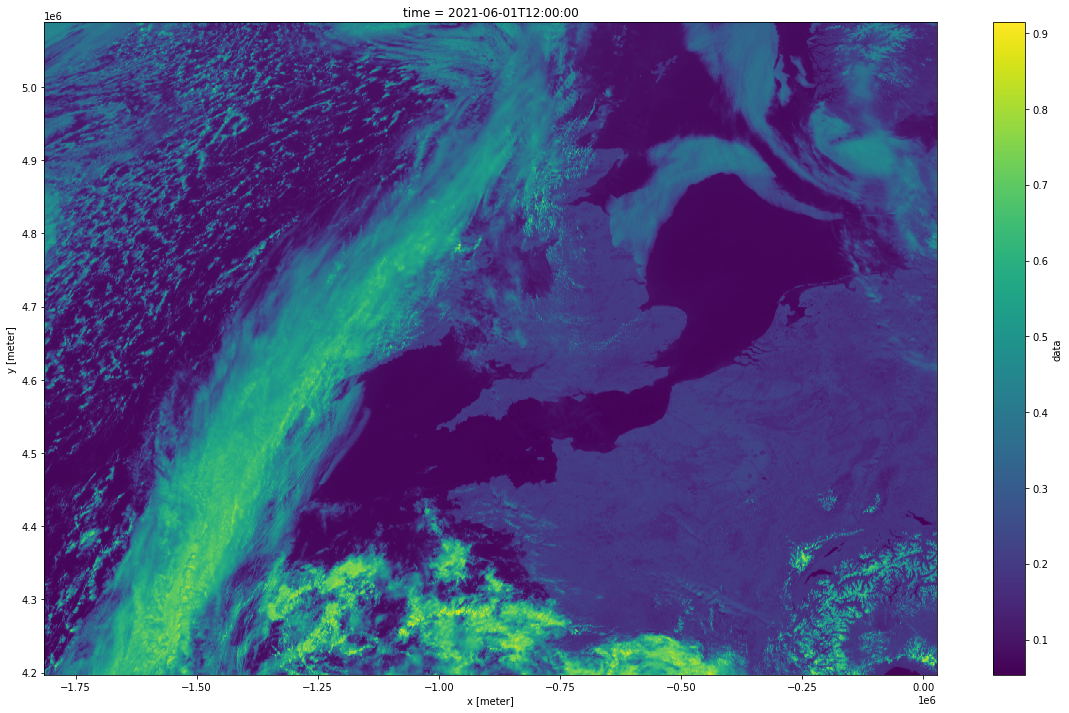

In [220]:
opened["data"].isel(time=0).plot();

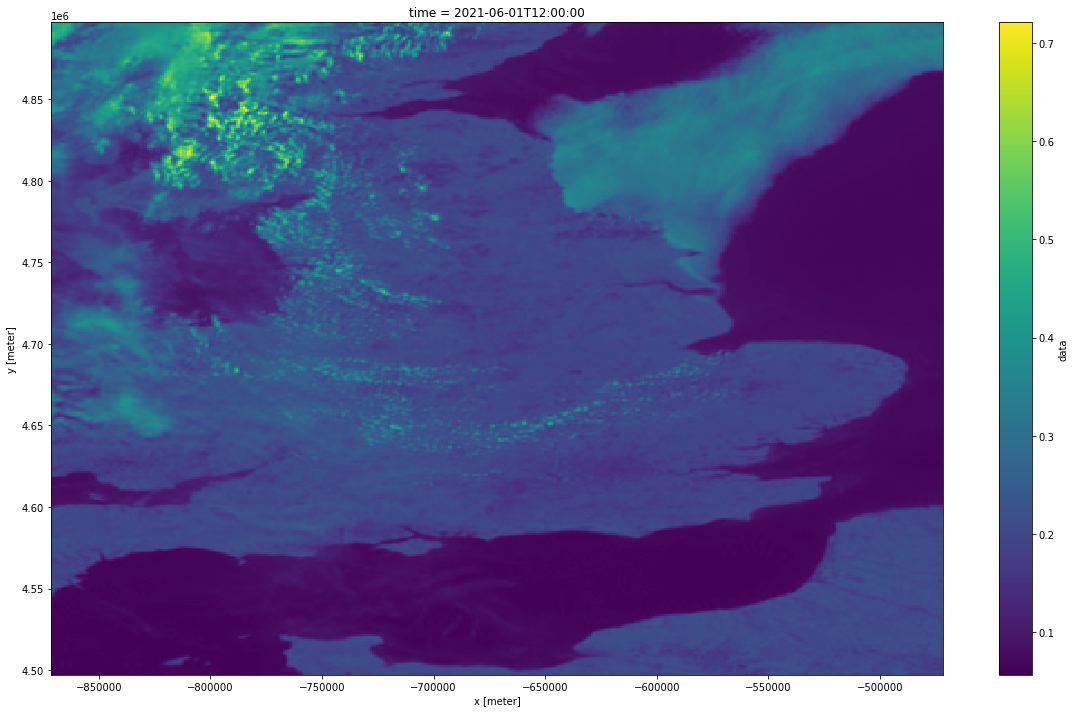

In [221]:
(opened["data"].isel(time=0, x=slice(500, 900), y=slice(300, 700))).plot();

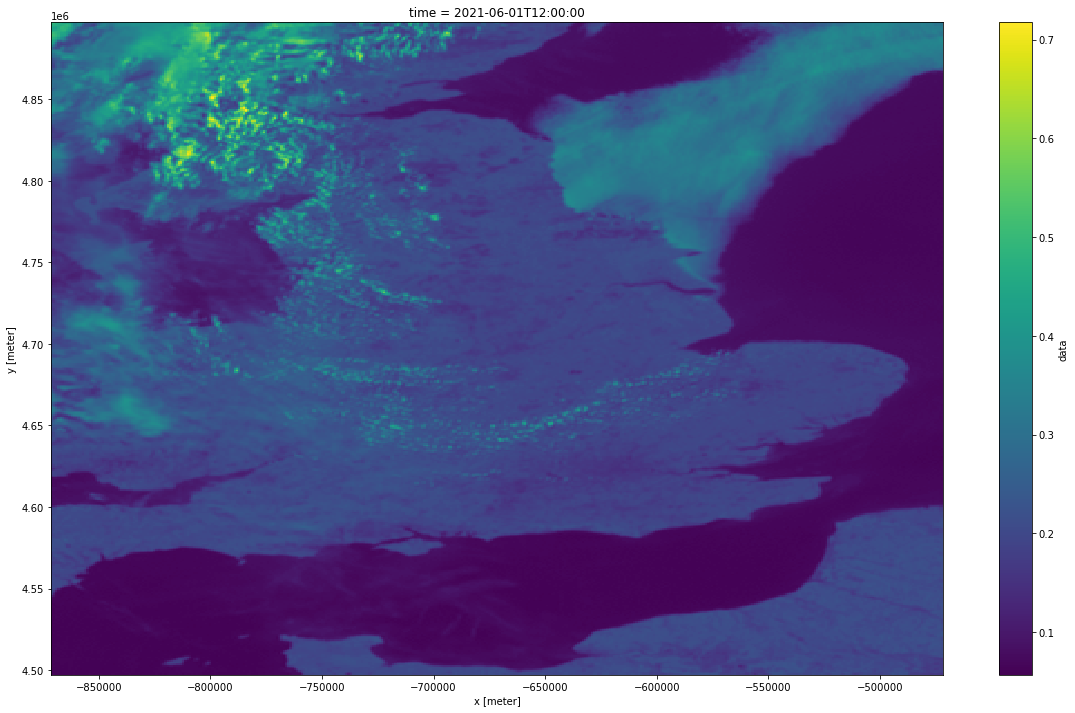

In [223]:
original_float16["data"].sel(time=DATETIME_TO_PLOT).isel(x=slice(500, 900), y=slice(300, 700)).plot();

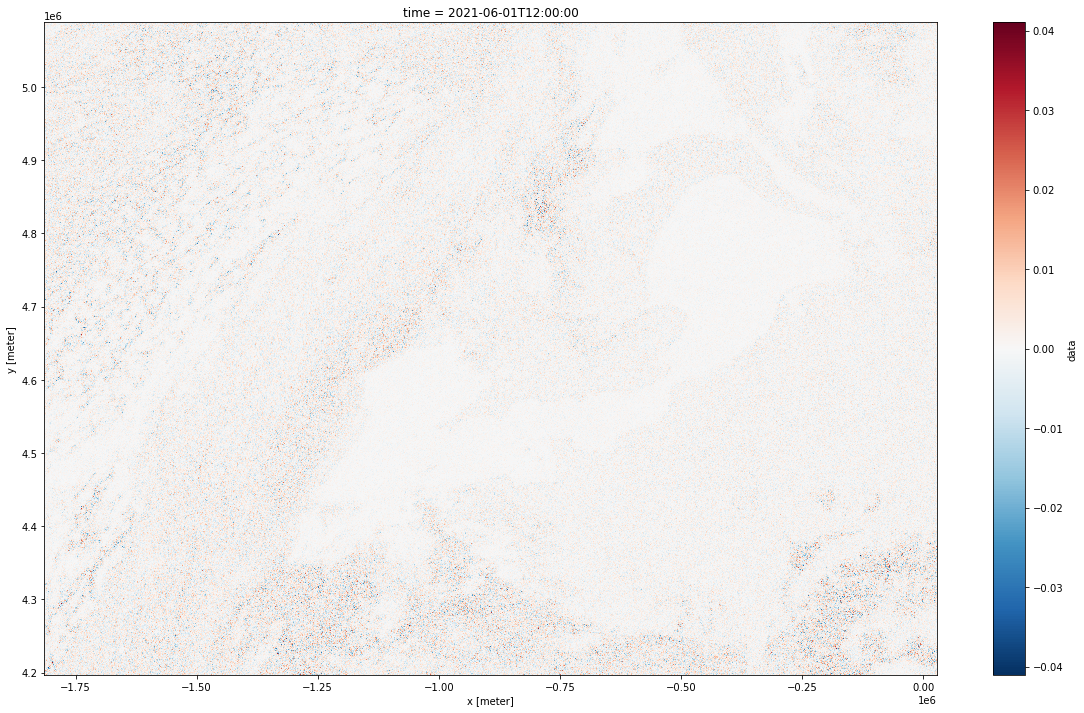

In [229]:
diff = ((opened["data"].astype(np.float32)) - (original_float16["data"].astype(np.float32)))
diff.isel(time=0).plot();

In [226]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [230]:
np.abs(diff).mean().compute().values

array(0.00147635, dtype=float32)

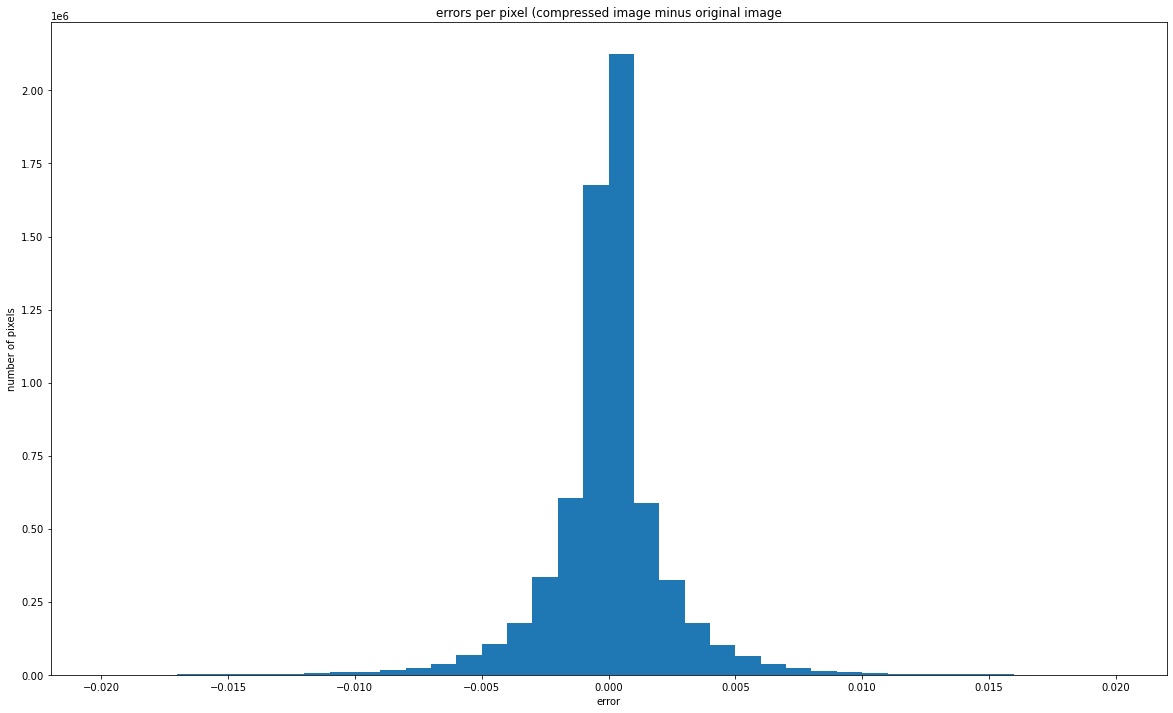

In [237]:
ax = plt.axes()
ax.hist(diff.values.flatten(), bins=np.arange(-0.02, 0.021, 0.001))
ax.set_title("errors per pixel (compressed image minus original image")
ax.set_ylabel("number of pixels")
ax.set_xlabel("error");

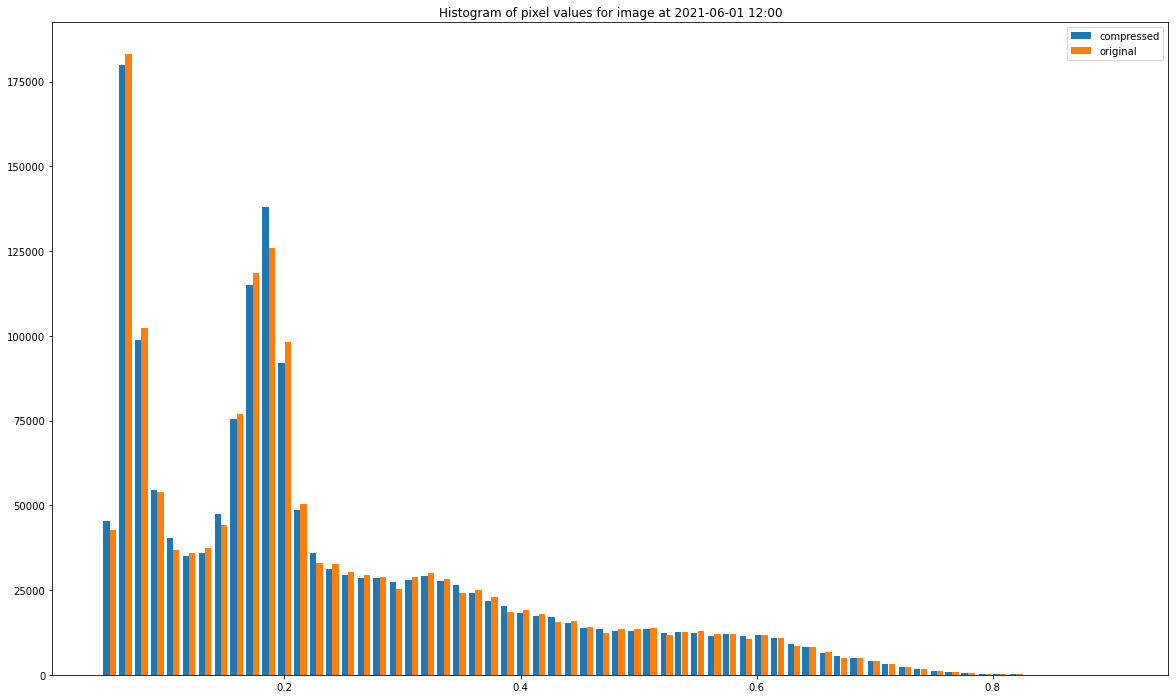

In [238]:
TIME_I = 0
ax = plt.axes()
ax.hist(
    (
        opened["data"].isel(time=TIME_I).values.flatten(),
        original_float16["data"].isel(time=TIME_I).values.flatten(),
    ),
    bins=64,
    align='left',
    label=["compressed", "original"]
);
ax.legend()
ax.set_title("Histogram of pixel values for image at " + pd.Timestamp(opened["data"].isel(time=TIME_I).time.values).strftime("%Y-%m-%d %H:%M"));

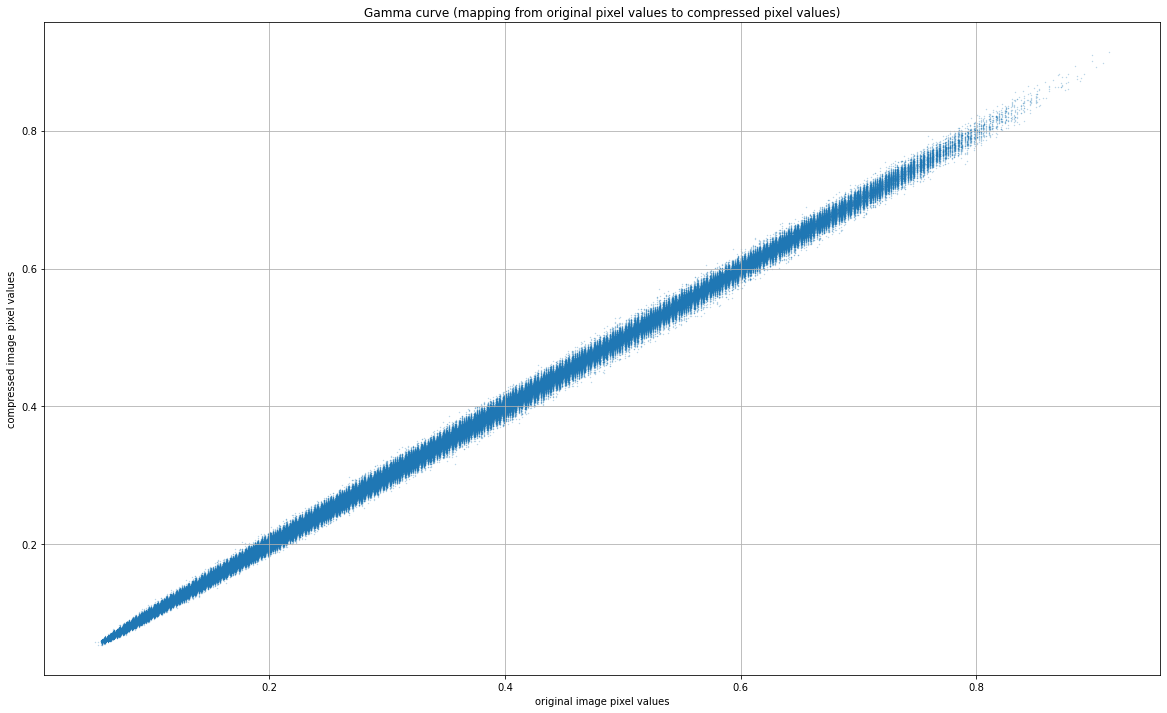

In [239]:
ax = plt.axes()
TIME_I = 0
ax.scatter(
    x=original_float16["data"].isel(time=TIME_I).values.flatten(),
    y=opened["data"].isel(time=TIME_I).values.flatten(),
    alpha=0.3,
    linewidth=0,
    s=2,
);
ax.grid(visible=True)
ax.set_title("Gamma curve (mapping from original pixel values to compressed pixel values)")
ax.set_xlabel("original image pixel values")
ax.set_ylabel("compressed image pixel values");